In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF" -O hw3_data.zip && rm -rf /tmp/cookies.txt
!unzip -qq hw3_data.zip -d dul_2021/Homework/hw5/data
!rm hw3_data.zip
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 260, done.
remote: Counting objects: 100% (260/260), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 260 (delta 120), reused 225 (delta 95), pack-reused 0
Receiving objects: 100% (260/260), 53.15 MiB | 30.70 MiB/s, done.
Resolving deltas: 100% (120/120), done.
--2021-12-10 00:01:13--  https://docs.google.com/uc?export=download&confirm=UUTa&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF
Resolving docs.google.com (docs.google.com)... 64.233.181.100, 64.233.181.139, 64.233.181.138, ...
Connecting to docs.google.com (docs.google.com)|64.233.181.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-a0-docs.googleusercontent.com/docs/securesc/5qcdj8s0a9rcgpgl6t5c6r9uecfgm6b6/kfdobn5b2raru1efka04vurjpnvjj5hm/1639094400000/06419056966375271799/17432233487193442736Z/1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF?e=download [following]
--2021-12-10 00:01:13--  https://doc-0c-a0-docs.go

In [2]:
from dul_2021.utils.hw5_utils import *

In [3]:
plt.rcParams["axes.labelsize"] = 25.
plt.rcParams["xtick.labelsize"] = 20.
plt.rcParams["ytick.labelsize"] = 20.
plt.rcParams["legend.fontsize"] = 18.

plt.rcParams["figure.figsize"] = [11., 8.]

# Question 1: VAEs on Images
In this question, you will train VAE models on image datasets. Execute the cell below to visualize the two datasets (colored shapes, and [SVHN](http://ufldl.stanford.edu/housenumbers/)).

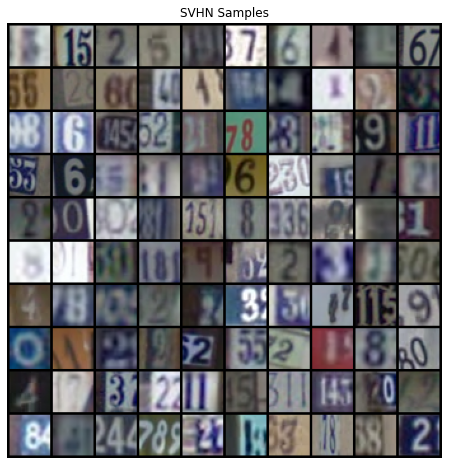

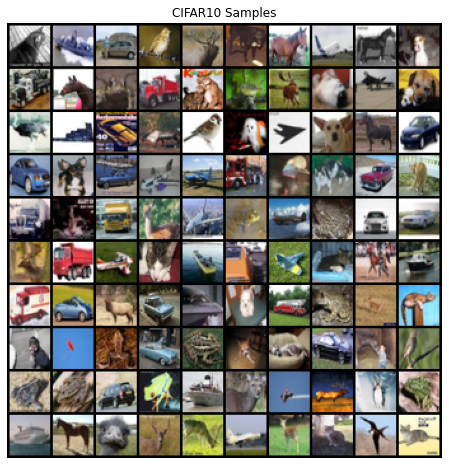

In [4]:
visualize_svhn()
visualize_cifar10()

## Part (a) VAE
In this part, implement a standard VAE with the following characteristics:

*   16-dim latent variables $z$ with standard normal prior $p(z) = N(0,I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. (We are not learning the covariance of the decoder)

You can play around with different architectures and try for better results, but the following encoder / decoder architecture below suffices (Note that image input is always $32\times 32$.
```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
    conv2d(3, 32, 3, 1, 1)
    relu()
    conv2d(32, 64, 3, 2, 1) # 16 x 16
    relu() 
    conv2d(64, 128, 3, 2, 1) # 8 x 8
    relu()
    conv2d(128, 256, 3, 2, 1) # 4 x 4
    relu()
    flatten()
    linear(4 * 4 * 256, 2 * latent_dim)

Decoder
    linear(latent_dim, 4 * 4 * 128)
    relu()
    reshape(4, 4, 128)
    transpose_conv2d(128, 128, 4, 2, 1) # 8 x 8
    relu()
    transpose_conv2d(128, 64, 4, 2, 1) # 16 x 16
    relu()
    transpose_conv2d(64, 32, 4, 2, 1) # 32 x 32
    relu()
    conv2d(32, 3, 3, 1, 1)
```

You may find the following training tips helpful
*   When computing reconstruction loss and KL loss, average over the batch dimension and **sum** over the feature dimension
*   When computing reconstruction loss, it suffices to just compute MSE between the reconstructed $x$ and true $x$ (you can compute the extra constants if you want)
*   Use batch size 128, learning rate $10^{-3}$, and an Adam optimizer




**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. Interpolations of length 10 between 10 pairs of test images from your VAE (100 images total)



### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [4]:
import torch
import torch.nn as nn
import numpy as np

In [5]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()
        conv_seq = nn.Sequential(self.block(3, 64, stride=1), 
                                 self.block(64, 128), 
                                 self.block(128, 256),
                                 self.block(256, 512))

        self.encoder = nn.Sequential(conv_seq, 
                                     nn.Flatten(), 
                                     nn.Linear(4 * 4 * 512, 2 * latent_dim))
        
    def block(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        return nn.Sequential(conv, nn.ReLU())

    def forward(self, x):
        return self.encoder(x)

In [6]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()
        self.linear = nn.Sequential(nn.Linear(latent_dim, 4 * 4 * 256),
                                    nn.ReLU())
        
        self.conv_seq = nn.Sequential(self.block(256, 256), 
                                      self.block(256, 128), 
                                      self.block(128, 64),
                                      nn.Conv2d(64, 3, 3, 1, 1))
        
    def block(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1):
        conv_t = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding)
        return nn.Sequential(conv_t, nn.ReLU())

    def forward(self, x):
        x = self.linear(x)
        x = x.view(-1, 256, 4, 4)
        return self.conv_seq(x)

In [15]:
class VAE(nn.Module):
    def __init__(self, latent_dim=16, device="cuda"):
        super().__init__()
        self.l_dim = latent_dim
        self.device = device
        self.encoder = Encoder(latent_dim).to(device)
        self.decoder = Decoder(latent_dim).to(device)

        self.opt_e = torch.optim.Adam(self.encoder.parameters())
        self.opt_d = torch.optim.Adam(self.decoder.parameters())
        
        self.standard_prior = torch.distributions.MultivariateNormal(torch.zeros(self.l_dim), 
                                                                     torch.diag(torch.ones(self.l_dim)))

    def forward(self, x):
        # Get mean and variance
        y = self.encoder(x)
        
        # Reparametrization
        eps = torch.normal(torch.zeros(x.shape[0], self.l_dim)).to(self.device)
        v = eps * torch.sqrt(y[:, self.l_dim:].abs()) 
        z = y[:, :self.l_dim] + v

        # Reconstruction
        d = self.decoder(z)

        return y, eps, z, d

    def sample(self, size):
        with torch.no_grad():
            z = self.standard_prior.sample((size,)).to(self.device)
            y = self.decoder(z)
            y = transform_back(y.cpu())
        
        return y

    def step(self, loss):
        self.opt_d.zero_grad()
        self.opt_e.zero_grad()
        
        loss.backward()

        self.opt_d.step()
        self.opt_e.step()

In [8]:
def transform(data):
    data = data.astype(np.float32)
    data /= 256 # 256
    data = torch.tensor(data)
    return torch.permute(data, (0, 3, 1, 2))

In [9]:
def transform_back(data):
    T = torch.permute(data, (0, 2, 3, 1)).clone()
    T *= 256 # 256
    T = T.numpy()
    T = np.clip(T, 0, 255).astype(np.uint8)
    return T

## Проверка, что `transform` работает

In [11]:
data_dir = get_data_dir(5)
train_data, test_data = load_pickled_data(join(data_dir, 'cifar10.pkl'))
tensor_train = transform(train_data)

In [12]:
train_back = transform_back(tensor_train[:2])

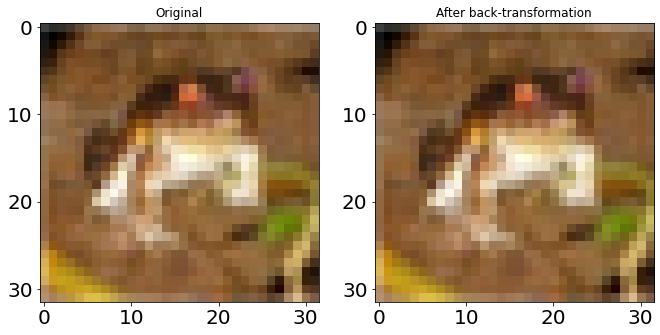

In [13]:
plt.subplot(1, 2, 1,)
plt.title("Original")
plt.imshow(train_data[0])

plt.subplot(1, 2, 2)
plt.title("After back-transformation")
plt.imshow(train_back[0])

plt.show()

## Main function

In [63]:
def q1_a(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-log p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """
    
    def iterate_over(vae, data, epoch):
        if epoch == 0:
            with torch.no_grad():
                y, eps, z, d = vae(data)
        else:
            y, eps, z, d = vae(data)

        variance = torch.abs(y[:, latent_dim:])

        log_q_zx = - eps ** 2
        log_q_zx -= torch.log(2 * np.pi * variance)
        log_q_zx *= 0.5

        p_z = - z * z
        p_z -= np.log(2 * np.pi)
        p_z *= 0.5

        # Compute loss
        # KL (q_zx || p_z)
        kld = kl_div(p_z, log_q_zx)
        
        # MSE (x|z, x)
        mmss = mse(data.flatten(), d.flatten()) * d.shape[2] * d.shape[3]
        return mmss, kld

    # Hyperparameters
    num_epochs = 30
    batch_size = 200
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    test_size = test_data.shape[0]
    train_size = train_data.shape[0]
    iteration_num = train_size // batch_size
    latent_dim = 16

    if dset_id == 1:
        kl_coef = 2.
        num_epochs = 25
    elif dset_id == 2:
        kl_coef = 4.
        batch_size = 50

    # Define model and losses
    vae = VAE(latent_dim, device).to(device)
    mse = nn.MSELoss()
    kl_div = nn.KLDivLoss(reduction='batchmean', log_target=True)

    # Transform data and bring it to device
    tensor_train = transform(train_data).to(device)
    tensor_test = transform(test_data).to(device)

    # Train metrics
    train_loss = np.zeros((num_epochs + 1, 3))
    train_mse = torch.zeros(num_epochs + 1).to(device)
    train_kld = torch.zeros(num_epochs + 1).to(device)

    # Test metrics
    test_loss = np.zeros((num_epochs + 1, 3))
    test_mse = torch.zeros(num_epochs + 1).to(device)
    test_kld = torch.zeros(num_epochs + 1).to(device)

    for epoch in range(num_epochs + 1):
        print(f"Epoch {epoch}")

        # Train dataset
        per = np.random.permutation(train_size)
        for it in range(iteration_num):
            idx = per[it * batch_size : (it + 1) * batch_size]
            data = tensor_train[idx]
            mmss, kld = iterate_over(vae, data, epoch)
            
            train_mse[epoch] += mmss.detach() * batch_size * 3
            train_kld[epoch] += kld.detach() * batch_size

            loss = mmss + kl_coef * kld

            if epoch > 0:
                vae.step(loss)

        print(f"\tMSE = {train_mse[epoch]}")
        print(f"\tDKL = {train_kld[epoch]}")
        # Test dataset
        per = np.random.permutation(test_size)
        for it in range(test_size // 500):
            idx = per[it * 500 : (it + 1) * 500]
            data = tensor_test[idx]
            mmss, kld = iterate_over(vae, data, 0)
            
            test_mse[epoch] += mmss.detach() * 500 * 3
            test_kld[epoch] += kld.detach() * 500
        
    # Drop from torch to numpy 
    train_loss[:, 1] = np.abs(train_mse.cpu().numpy())
    train_loss[:, 2] = np.abs(train_kld.cpu().numpy())
    train_loss[:, 0] = np.log(train_loss[:, 1] + train_loss[:, 2])
    train_loss[:, 1] = np.log(train_loss[:, 1])
    train_loss[:, 2] = np.log(train_loss[:, 2])
    
    test_loss[:, 1] = np.abs(test_mse.cpu().numpy())
    test_loss[:, 2] = np.abs(test_kld.cpu().numpy())
    test_loss[:, 0] = np.log(test_loss[:, 1] + test_loss[:, 2])
    test_loss[:, 1] = np.log(test_loss[:, 1])
    test_loss[:, 2] = np.log(test_loss[:, 2])

    # Sampling
    samples = vae.sample(100)

    # Reconstruction
    reconstructions = np.zeros((100, 32, 32, 3))  
    with torch.no_grad():
        test_size = test_data.shape[0]
        ids = np.random.randint(0, test_size, 50)
        original = test_data[ids]
        
        _, _, _, out = vae(tensor_test[ids])
        rec = transform_back(out.cpu())

        for i in range(50):
            reconstructions[2 * i] = original[i]
            reconstructions[2 * i + 1] = rec[i]

    # Interpolation
    interpolations = np.zeros((100, 32, 32, 3))
    with torch.no_grad():
        z = vae.standard_prior.sample((100,)).to(device)
        for i in range(10):
            delta = (z[10 * (i + 1) - 1] - z[10 * i]) / 9
            for j in range(1, 10):
                z[10 * i + j] = z[10 * i] + j * delta

        result = vae.decoder(z)
        interpolations = transform_back(result.cpu()) 

    return train_loss, test_loss, samples, reconstructions, interpolations

### Results
Once you've finished `q1_a`, execute the cells below to visualize and save your results.

Epoch 0
	MSE = 7420408.5
	DKL = 1431294.875
Epoch 1
	MSE = 4109741.25
	DKL = 40757.125
Epoch 2
	MSE = 728873.75
	DKL = 3581.374267578125
Epoch 3
	MSE = 663710.0
	DKL = 3115.57666015625
Epoch 4
	MSE = 653883.9375
	DKL = 3457.229736328125
Epoch 5
	MSE = 639615.8125
	DKL = 4209.87255859375
Epoch 6
	MSE = 622081.4375
	DKL = 5593.13427734375
Epoch 7
	MSE = 606531.5
	DKL = 6776.3115234375
Epoch 8
	MSE = 595845.625
	DKL = 7389.1337890625
Epoch 9
	MSE = 586243.9375
	DKL = 7973.13818359375
Epoch 10
	MSE = 581041.75
	DKL = 8315.880859375
Epoch 11
	MSE = 573977.5
	DKL = 8787.1171875
Epoch 12
	MSE = 570504.0
	DKL = 9155.5126953125
Epoch 13
	MSE = 558623.4375
	DKL = 9352.294921875
Epoch 14
	MSE = 557476.5
	DKL = 9684.7431640625
Epoch 15
	MSE = 547788.8125
	DKL = 9934.931640625
Epoch 16
	MSE = 541751.3125
	DKL = 10436.302734375
Epoch 17
	MSE = 526602.6875
	DKL = 11049.89453125
Epoch 18
	MSE = 520185.875
	DKL = 11801.947265625
Epoch 19
	MSE = 512480.28125
	DKL = 12232.853515625
Epoch 20
	MSE = 506276

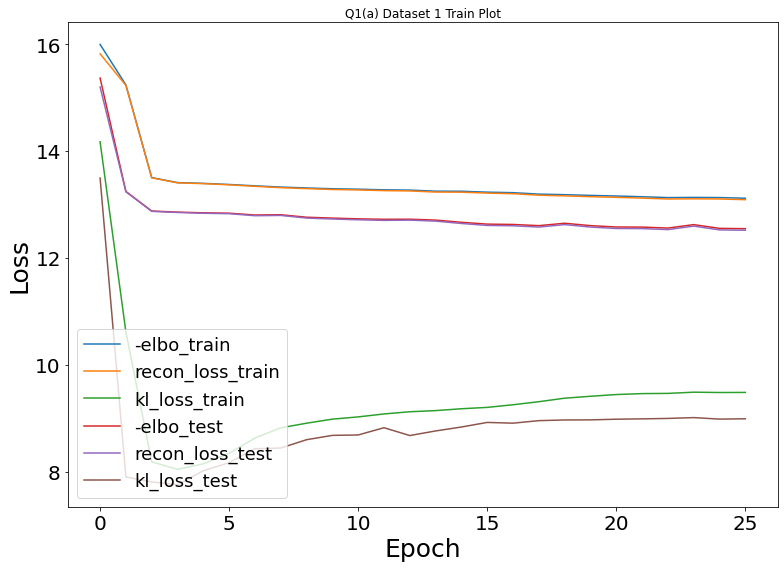

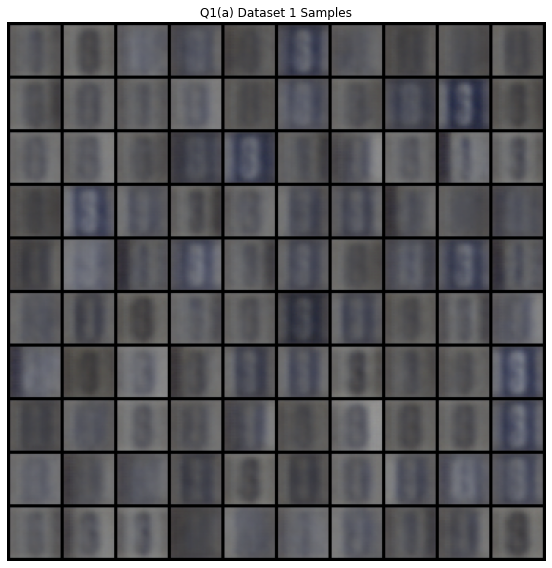

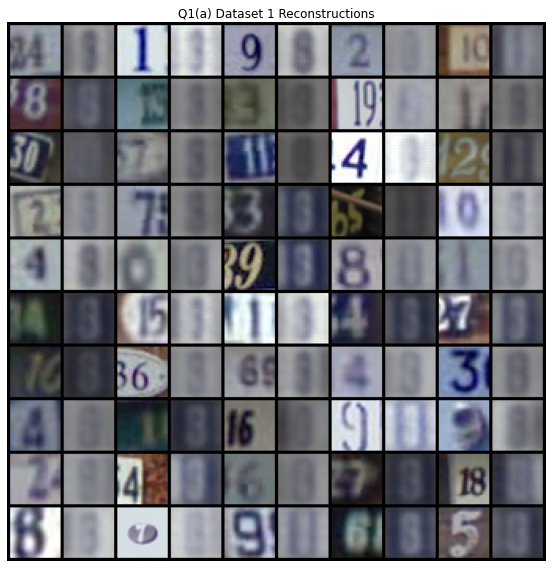

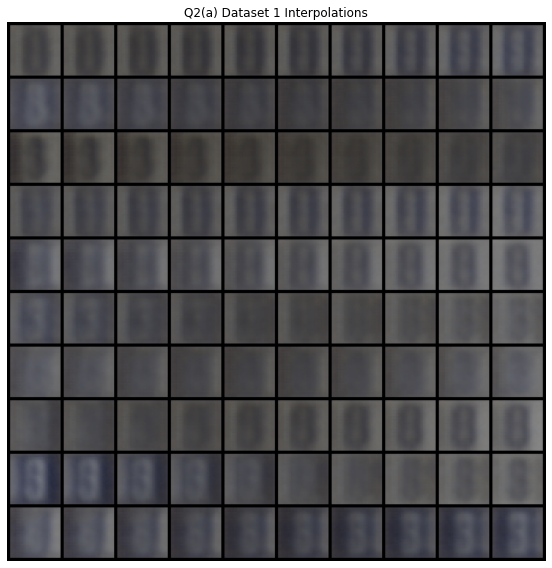

In [64]:
q1_save_results('a', 1, q1_a) # All losses in log_space

Epoch 0
	MSE = 10409654.0
	DKL = 2075335.25
Epoch 1
	MSE = 2967782.5
	DKL = 14885.1513671875
Epoch 2
	MSE = 1645595.625
	DKL = 9925.234375
Epoch 3
	MSE = 1527737.0
	DKL = 13517.0478515625
Epoch 4
	MSE = 1454264.75
	DKL = 15616.90234375
Epoch 5
	MSE = 1625156.125
	DKL = 14915.4033203125
Epoch 6
	MSE = 1428964.5
	DKL = 16882.169921875
Epoch 7
	MSE = 1389294.25
	DKL = 17892.896484375
Epoch 8
	MSE = 1371205.375
	DKL = 18523.373046875
Epoch 9
	MSE = 1369901.25
	DKL = 18726.650390625
Epoch 10
	MSE = 1364673.75
	DKL = 18663.375
Epoch 11
	MSE = 1358985.125
	DKL = 18930.203125
Epoch 12
	MSE = 1350398.125
	DKL = 19111.869140625
Epoch 13
	MSE = 1359494.125
	DKL = 19280.90234375
Epoch 14
	MSE = 1349162.625
	DKL = 19103.794921875
Epoch 15
	MSE = 1347838.375
	DKL = 19533.08984375
Epoch 16
	MSE = 1333270.5
	DKL = 19746.455078125
Epoch 17
	MSE = 1335510.0
	DKL = 19772.806640625
Epoch 18
	MSE = 1326071.5
	DKL = 20023.72265625
Epoch 19
	MSE = 1330257.25
	DKL = 20435.44140625
Epoch 20
	MSE = 1320699.375


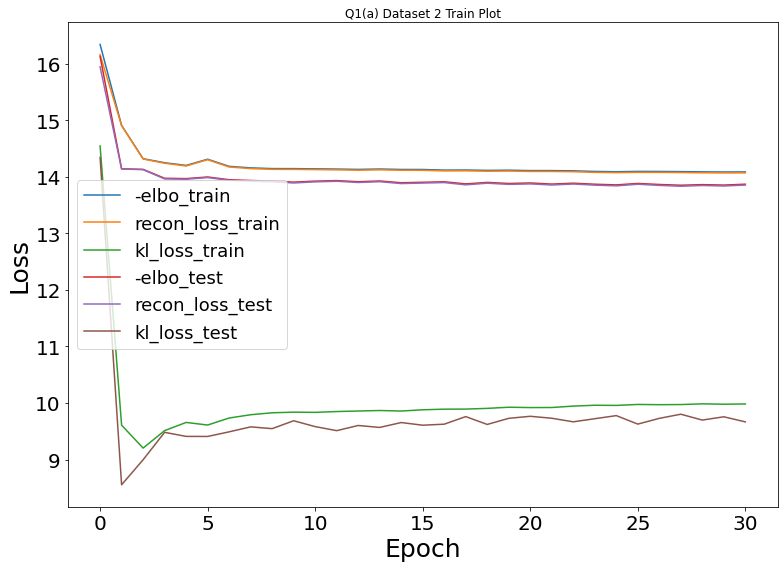

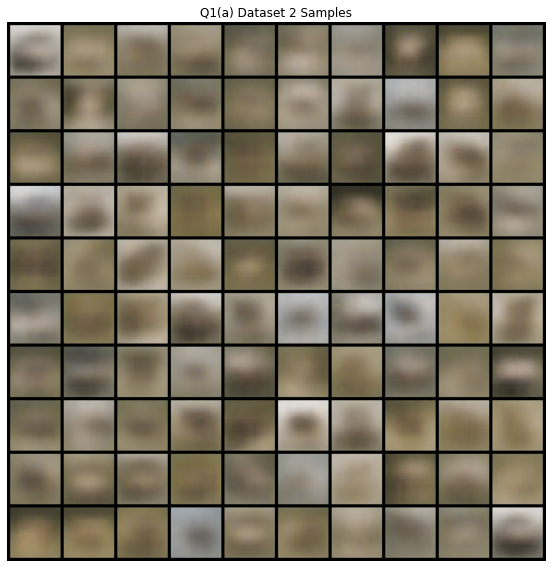

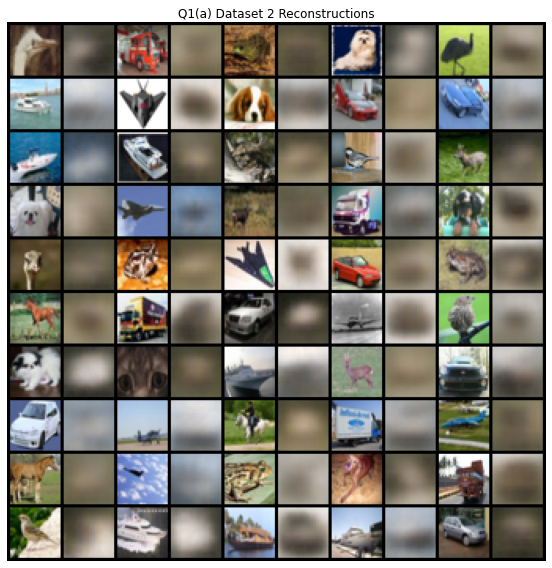

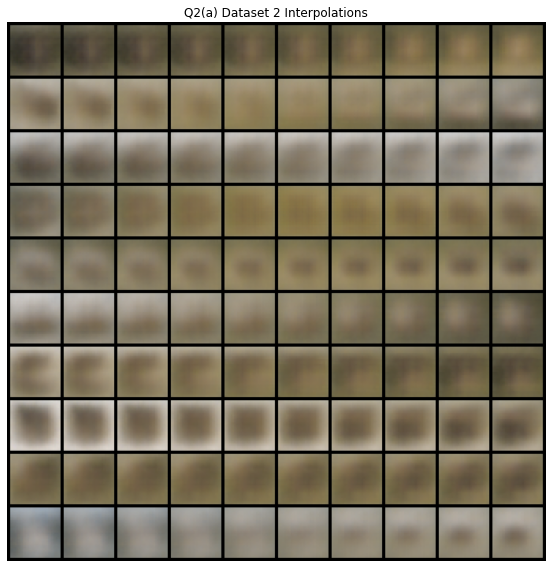

In [54]:
q1_save_results('a', 2, q1_a) # All losses in log space

In [ ]:
q1_save_results('b', 2, q1_b)